In [1]:
import csv
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (16,9)
rcParams['font.size'] = 12
import numpy as np
import scipy as sp
import os 
import glob
import pandas as pd
import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)

data_path = os.getcwd()
data_extension = "csv"

os.chdir(data_path)

In [2]:
result = glob.glob("./finishedLogs/" + '*.{}'.format(data_extension))

print(result)

['./finishedLogs/5-5-f.csv', './finishedLogs/5-3-f.csv', './finishedLogs/5-1-f.csv', './finishedLogs/5-4-f.csv', './finishedLogs/5-0-f.csv', './finishedLogs/5-2-f.csv']


In [3]:
dff = [pd.read_csv(f, delimiter = ',') for f in result]

concats = {}

for df in dff:
    condition_id = list(df["condition_id"])[0]
    
    if not condition_id in concats:
        concats[condition_id] = df
    else:
        concats[condition_id] = pd.concat([concats[condition_id], df])
        
dff = concats.values()

pids = list(concats[0].pid.unique())

In [4]:
import math

class Run:
    def __init__(self, data):
        self.data = data
                
        self.condition = list(data["condition_id"])[0]
        
        self.pid = list(data["pid"])[-1]        
        self.run_id = list(data["run_id"])[-1]
        self.run_starttime = list(data["timestampConditionStart"])[-1]
        
        self.successful_click_time = list(data["timestampClick"])[0]
        
        self.errors = -1
    
        for i in list(data["timestampClick"]):
            if self.successful_click_time != i:
                self.errors += 1
                self.successful_click_time = i
                
        self.run_duration = self.successful_click_time - self.run_starttime
        
        ###########################
        self.collisions = 0
        initial_collision_ts = list(data["timestampCollision"])[0]

        for i in list(data["timestampCollision"]):
            if initial_collision_ts != i:
                self.collisions += 1
                initial_collision_ts = i
                
        self.run_duration = self.successful_click_time - self.run_starttime
        
        
        ##############################
       
        self.num_cursor_movements = 0
        self.cursor_movement_length = 0
        self.num_target_movements = 0
        self.target_movement_length = 0
        
        initial_cursor_x = int(float(list(data["cursorX"])[0]))
        initial_cursor_y = int(float(list(data["cursorY"])[0]))
        initial_target_x = int(float(list(data["targetX"])[0]))
        initial_target_y = int(float(list(data["targetY"])[0]))
        
        for i in range(0, len(list(data["cursorX"]))):
            x, y = int(float(list(data["cursorX"])[i])), int(float(list(data["cursorY"])[i]))
            tx, ty = int(float(list(data["targetX"])[i])), int(float(list(data["targetY"])[i]))
            
            if x != initial_cursor_x or y != initial_cursor_y:
                self.cursor_movement_length += self.vector_length(x - initial_cursor_x, y - initial_cursor_y)
                self.num_cursor_movements += 1
                initial_cursor_x = x
                initial_cursor_y = y
                
            if tx != initial_target_x or ty != initial_target_y:
                self.num_target_movements += 1
                self.target_movement_length += self.vector_length(tx - initial_target_x, ty - initial_target_y)
                initial_target_x = tx
                initial_target_y = ty
              
    def __repr__(self):
        return "condition:{0}\npid: {1}\nrun_id: {2}\ncollisions:{3}\nerrors:{4}\nduration:{5} ms\ncursor movements:{6}\ncursor movement length:{7}\ntarget movements:{8}\ntarget movement length:{9}\n\n".format(
            self.condition,
            self.pid,
            self.run_id,
            self.collisions,
            self.errors,
            self.run_duration,
            self.num_cursor_movements,
            self.cursor_movement_length,
            self.num_target_movements,
            self.target_movement_length)
    
    def vector_length(self, u, v):
        return math.sqrt(u * u + v * v)
    

In [5]:
conditions = []

for df in dff:
    conditions.append([])
    
    for pid in pids:
        dfp = df[df["pid"] == pid]
        
        for rid in range(1, max(df["run_id"])):
            dfpr = dfp[dfp["run_id"] == rid]
            
            conditions[-1].append(Run(dfpr))

# Results

## Duration

condition: Static UI with 1.5x CD Gain has mean duration of 781.9387755102041 ms
condition: Static UI with 1.5x CD Gain has median duration of 707.0 ms

condition: Factor 0.75 MUI has mean duration of 731.7142857142857 ms
condition: Factor 0.75 MUI has median duration of 665.5 ms

condition: Factor 0.25 MUI has mean duration of 760.8163265306123 ms
condition: Factor 0.25 MUI has median duration of 701.5 ms

condition: Factor 0.1 MUI has mean duration of 732.3877551020408 ms
condition: Factor 0.1 MUI has median duration of 657.0 ms

condition: Static UI has mean duration of 788.1428571428571 ms
condition: Static UI has median duration of 743.5 ms

condition: Factor 0.5 MUI has mean duration of 758.9795918367347 ms
condition: Factor 0.5 MUI has median duration of 686.5 ms



([<matplotlib.axis.XTick at 0x7f9a88776350>,
 <a list of 6 Text xticklabel objects>)

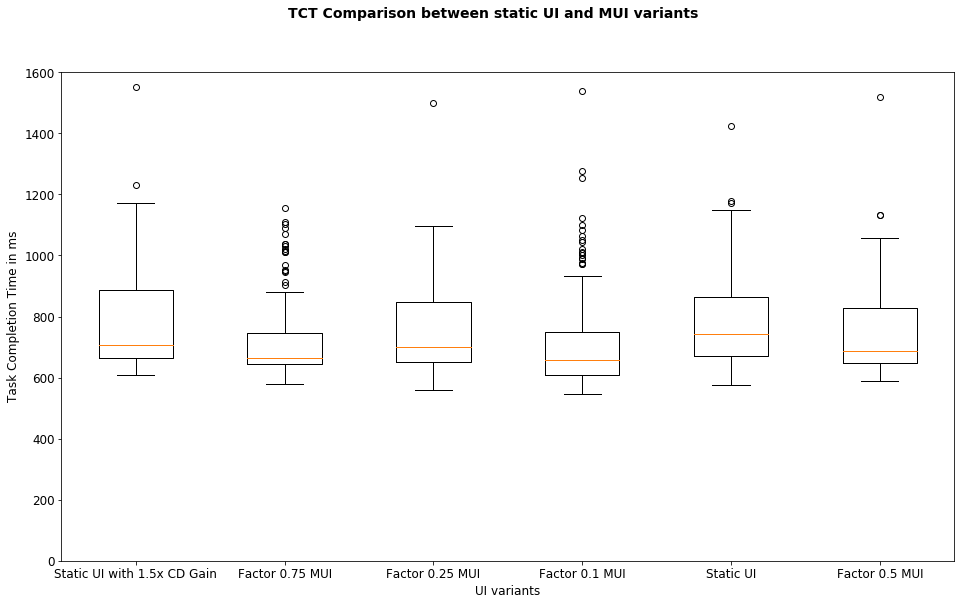

In [6]:
durations = {}

for condition in conditions:
    durations[condition[0].condition] = [run.run_duration for run in condition]
        
ticks = []
data = []

for condition, duration_measurements in durations.items(): 
    cond_name = "Static UI" if condition == 0 else "Factor 0.25 MUI" if condition == 1 else "Factor 0.5 MUI" if condition == 2 else "Factor 0.75 MUI" if condition == 3 else "Factor 0.1 MUI" if condition == 4  else "Static UI with 1.5x CD Gain"
    
    print("condition: {0} has mean duration of {1} ms".format(cond_name, np.mean(duration_measurements)))
    print("condition: {0} has median duration of {1} ms".format(cond_name, np.median(duration_measurements)))
    print()
    
    data.append(duration_measurements)
    ticks.append(cond_name)

fig = plt.figure()
fig.suptitle('TCT Comparison between static UI and MUI variants', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xlabel('UI variants')
ax.set_ylabel('Task Completion Time in ms')
ax.set_ylim(bottom=0)
xticks([i + 1 for i in range(len(ticks))], ticks)


In [7]:
from scipy.stats import ttest_rel as ttest

static_durations = durations[0]
factor025_durations = durations[1]
factor05_durations = durations[2]
factor075_durations = durations[3]
factor1_durations = durations[4]
static15cdg_durations = durations[5]

def getConditionName(cond):
    cond_name = "Static UI" if cond == 0 else "Factor 0.25 MUI" if cond == 1 else "Factor 0.5 MUI" if cond == 2 else "Factor 0.75 MUI" if cond == 3 else "Factor 0.1 MUI" if cond == 4  else "Static UI with 1.5x CD Gain"
    return cond_name
    
for cond in range(6):
    cond_name = getConditionName(cond)
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> p = {}".format(ttest(durations[cond], durations[condToCompare])[1]))
    print()

Static UI vs Factor 0.25 MUI -> p = 0.23612321999608668
Static UI vs Factor 0.5 MUI -> p = 0.20849994402937855
Static UI vs Factor 0.75 MUI -> p = 0.018909657889954037
Static UI vs Factor 0.1 MUI -> p = 0.03384816647649724
Static UI vs Static UI with 1.5x CD Gain -> p = 0.8081913992555787

Factor 0.25 MUI vs Static UI -> p = 0.23612321999608668
Factor 0.25 MUI vs Factor 0.5 MUI -> p = 0.9382563708439564
Factor 0.25 MUI vs Factor 0.75 MUI -> p = 0.16789914333503222
Factor 0.25 MUI vs Factor 0.1 MUI -> p = 0.2863619392441344
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> p = 0.367189447435571

Factor 0.5 MUI vs Static UI -> p = 0.20849994402937855
Factor 0.5 MUI vs Factor 0.25 MUI -> p = 0.9382563708439564
Factor 0.5 MUI vs Factor 0.75 MUI -> p = 0.22270807989798475
Factor 0.5 MUI vs Factor 0.1 MUI -> p = 0.2776766222344179
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> p = 0.3265157775986318

Factor 0.75 MUI vs Static UI -> p = 0.018909657889954037
Factor 0.75 MUI vs Factor 0.25 MU

## Errors

In [8]:
def increase_in_percent(counter, denominator):
    return (counter / (denominator / 100)) - 100

errors = {}

for condition in conditions:
    errors[condition[0].condition] = sum([run.errors for run in condition])

for cond in range(6):
    cond_name = getConditionName(cond)
    print("Errors for " + cond_name + ": {}".format(errors[cond]))
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> p = {}%".format(increase_in_percent(errors[cond], errors[condToCompare])))
    print("")

Errors for Static UI: 14
Static UI vs Factor 0.25 MUI -> p = -6.666666666666657%
Static UI vs Factor 0.5 MUI -> p = -22.222222222222214%
Static UI vs Factor 0.75 MUI -> p = -17.64705882352942%
Static UI vs Factor 0.1 MUI -> p = -39.130434782608695%
Static UI vs Static UI with 1.5x CD Gain -> p = -36.36363636363637%

Errors for Factor 0.25 MUI: 15
Factor 0.25 MUI vs Static UI -> p = 7.142857142857139%
Factor 0.25 MUI vs Factor 0.5 MUI -> p = -16.666666666666657%
Factor 0.25 MUI vs Factor 0.75 MUI -> p = -11.764705882352942%
Factor 0.25 MUI vs Factor 0.1 MUI -> p = -34.78260869565217%
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> p = -31.818181818181813%

Errors for Factor 0.5 MUI: 18
Factor 0.5 MUI vs Static UI -> p = 28.571428571428555%
Factor 0.5 MUI vs Factor 0.25 MUI -> p = 20.0%
Factor 0.5 MUI vs Factor 0.75 MUI -> p = 5.882352941176464%
Factor 0.5 MUI vs Factor 0.1 MUI -> p = -21.73913043478261%
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> p = -18.181818181818187%

Errors 

## Covered Distances

In [9]:
# covered_distance
mean_covered_distances_cursor = {}

for condition in conditions:
    mean_covered_distances_cursor[condition[0].condition] = sum([run.cursor_movement_length for run in condition]) / len([run.cursor_movement_length for run in condition])

In [10]:
static_mean_covered_distance = mean_covered_distances_cursor[0]
factor05_mean_covered_distance = mean_covered_distances_cursor[1]
factor1_mean_covered_distance = mean_covered_distances_cursor[2]
static15cdg_mean_covered_distance = mean_covered_distances_cursor[3]


for cond in range(6):
    cond_name = getConditionName(cond)
    print("Mean covered distance of cursor for " + cond_name + ": {}px".format(mean_covered_distances_cursor[cond]))

Mean covered distance of cursor for Static UI: 356.8646836358766px
Mean covered distance of cursor for Factor 0.25 MUI: 308.84094915734704px
Mean covered distance of cursor for Factor 0.5 MUI: 289.5096205188403px
Mean covered distance of cursor for Factor 0.75 MUI: 263.7497321474153px
Mean covered distance of cursor for Factor 0.1 MUI: 241.85478666613196px
Mean covered distance of cursor for Static UI with 1.5x CD Gain: 409.34150190187046px


## Most notable observation

WIP